# Kaggle [bioresponse competition](https://www.kaggle.com/c/bioresponse/rules) with XGBoost and Ensembles.
### The code was presented in [ML online course by Yandex and MIPT](https://www.coursera.org/learn/supervised-learning).

In [1]:
from sklearn import ensemble, model_selection, metrics
from sklearn import neural_network as nn
import xgboost as xgb
import pandas as pd
import numpy as np

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
warnings.filterwarnings("ignore")

Read train data.

In [4]:
bioresponse = pd.read_csv('./bioresponse_dataset/train.csv', header=0, sep=',')

In [5]:
bioresponse.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Separate data and labels

In [6]:
bioresponse_label = bioresponse['Activity']
bioresponse_label.head()

0    1
1    1
2    1
3    1
4    0
Name: Activity, dtype: int64

In [7]:
bioresponse_data = bioresponse.iloc[:, 1:]
bioresponse_data.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,0.243144,...,0,0,0,0,0,0,0,0,0,0
1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,0.106480,...,1,1,1,1,0,1,0,0,1,0
2,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,0.352308,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,0.208989,...,0,0,0,0,0,0,0,0,0,0
4,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,0.125177,...,0,0,0,0,0,0,0,0,0,0


In [8]:
bioresponse_data.shape

(3751, 1776)

Check balance of classes in dataset.

In [9]:
print('No response instances: ', 
      bioresponse.loc[bioresponse['Activity'] == 0].shape[0])
print('Response instances: ', 
      bioresponse.loc[bioresponse['Activity'] == 1].shape[0])

No response instances:  1717
Response instances:  2034


Dataset slightly skewed to the Response class.

### Random Forest

In [10]:
num_trees = np.arange(5, 100, 5)
num_trees

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])

In [11]:
%%time
accs = []
num_folds = 5
min_split = 5
for num_tree in num_trees:
    clf = ensemble.RandomForestClassifier(n_estimators=num_tree, 
                                          min_samples_split=min_split, random_state=1)
    tmp_acc = model_selection.cross_val_score(clf, bioresponse_data, 
                                              bioresponse_label, scoring='accuracy',
                                              cv=num_folds)
    accs.append(tmp_acc)

Wall time: 1min 22s


In [12]:
matrix_accs = np.asmatrix(accs)

In [13]:
mean_accs = matrix_accs.mean(1)
std_accs = matrix_accs.std(1)
conf_95 = 1.96 * (std_accs / np.sqrt(num_folds))

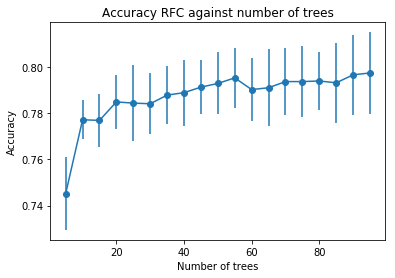

In [14]:
pylab.errorbar(num_trees, mean_accs, conf_95, fmt='-o')
pylab.xlabel('Number of trees')
pylab.ylabel('Accuracy')
pylab.title('Accuracy RFC against number of trees')
pylab.show()

### XGBoost

In [15]:
%%time
xgb_accs = []
for num_tree in num_trees:
    clf = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=num_tree,
                            min_child_weight=3, random_state=1)
    tmp_acc = model_selection.cross_val_score(clf, bioresponse_data, bioresponse_label,
                                           scoring='accuracy', cv=num_folds)
    xgb_accs.append(tmp_acc)

Wall time: 10min 42s


In [16]:
xgb_matrix = np.asmatrix(xgb_accs)

In [17]:
xgb_mean_accs = xgb_matrix.mean(1)
xgb_std = xgb_matrix.std(1)
conf_95_xgb = 1.96 * (xgb_std / np.sqrt(num_folds))

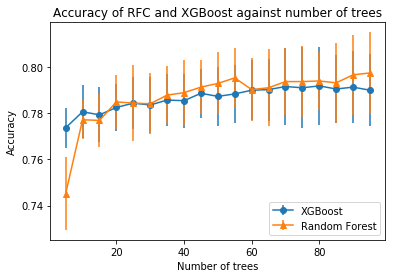

In [18]:
pylab.errorbar(num_trees, xgb_mean_accs, conf_95_xgb, fmt='-o', label='XGBoost')
pylab.errorbar(num_trees, mean_accs, conf_95, fmt='-^', label='Random Forest')
pylab.xlabel('Number of trees')
pylab.ylabel('Accuracy')
pylab.title('Accuracy of RFC and XGBoost against number of trees')
pylab.legend(loc='lower right')
pylab.show()

In [19]:
num_trees_for_RF = num_trees[mean_accs.tolist().index(max(mean_accs))]
num_trees_for_XGB = num_trees[xgb_mean_accs.tolist().index(max(xgb_mean_accs))]

In [20]:
num_trees_for_RF

95

In [21]:
num_trees_for_XGB

80

As we can see above, the accuracies of RFC and XGBoost are about the same for the datasets. However, RFC perfomance becomes better with growth of the number of trees while XGBoost accuracy increases not so significantly. 

The learning time for RFC is much smaller than learning time for XGBoost.

### Build models for test dataset. 

In [56]:
bioresponse_test_data = pd.read_csv('./bioresponse_dataset/test.csv', header=0)
bioresponse_test_data.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,0.366667,0.611765,0.05,0.0,0.110435,0.803973,0.106075,0.473965,0.835617,0.106452,...,1,1,1,1,0,1,0,0,1,0
1,0.100000,0.758175,0.30,0.0,0.180128,0.621378,0.287144,0.503919,0.674919,0.403616,...,0,0,0,0,0,0,0,0,0,0
2,0.100000,0.658812,0.10,0.0,0.243421,0.640959,0.312765,0.279784,0.686775,0.280301,...,0,0,0,0,0,0,0,0,0,0
3,0.100000,0.655752,0.10,0.0,0.226978,0.776996,0.150657,0.336948,0.802121,0.125608,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.484851,0.00,0.0,0.561200,0.771463,0.244287,0.293096,0.717575,0.230842,...,0,0,0,0,0,0,0,0,0,0


In [57]:
rf_clf = ensemble.RandomForestClassifier(n_estimators=num_trees_for_RF, 
                                          min_samples_split=min_split, random_state=1)
rf_clf.fit(bioresponse_data, bioresponse_label)
rf_predicted = rf_clf.predict_proba(bioresponse_test_data)

In [76]:
rf_predicted_df = pd.DataFrame(rf_predicted)
rf_predicted_prob = rf_predicted_df.iloc[:, 1]
rf_predicted_prob.index += 1
rf_predicted_prob.head()

1    0.881053
2    0.902281
3    0.614971
4    0.944737
5    0.224035
Name: 1, dtype: float64

In [68]:
xgb_clf = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=num_trees_for_XGB,
                            min_child_weight=3, random_state=1)
xgb_clf.fit(bioresponse_data, bioresponse_label)
xgb_predicted = xgb_clf.predict_proba(bioresponse_test_data)

In [79]:
xgb_predicted_df = pd.DataFrame(xgb_predicted)
xgb_predicted_prob = xgb_predicted_df.iloc[:, 1]
xgb_predicted_prob.index += 1
xgb_predicted_prob.head()

1    0.744112
2    0.963424
3    0.301003
4    0.937778
5    0.058175
Name: 1, dtype: float32

In [80]:
rf_predicted_prob.to_csv('./bioresponse_dataset/RF_predicted.csv', header=['PredictedProbability'], index=True, index_label = ['MoleculeId'])
xgb_predicted_prob.to_csv('./bioresponse_dataset/XGB_predicted.csv', header=['PredictedProbability'], index=True, index_label = ['MoleculeId'])

Files were submitted to Kaggle. The testing system calculates the **logloss** function. Results are not availaible at leaderboard because competition was closed many years ago..

Random Forest Classifier: 0.40892

XGBoost: 0.42094